# This entire notebook is the work of Alex Howe!

In [43]:
import pandas as pd
import numpy as np
from scapy.all import *
from collections import defaultdict
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, classification_report
from concurrent.futures import ProcessPoolExecutor
from sklearn.exceptions import NotFittedError


In [39]:
packets = rdpcap("Modbus_polling_only_6RTU.pcap")
packets

<Modbus_polling_only_6RTU.pcap: TCP:58044 UDP:172 ICMP:0 Other:109>

In [41]:
packets[1].time - packets[0].time

Decimal('0.000159')

In [42]:
packets[0].src

'00:0c:29:ee:b7:84'

In [46]:
packets[0][Ether].fields["src"]

'00:0c:29:ee:b7:84'

In [ ]:
def load_attack_labels(label_file):
    df = pd.read_csv(label_file, sep=';', header=None, names=['packet_index', 'label'])
    return df['label'].values  # Only return the label column as an array
# Step 1: Parse the pcap file and extract packet timestamps and conversations
def parse_pcap(file):
    packets = rdpcap(file)
    conversations = defaultdict(list)
    packet_indices = defaultdict(list)  # To store global indices of packets in each conversation

    if len(packets) == 0:
        return conversations, packet_indices, len(packets)

    first_packet_time = float(packets[0].time)

    for i, packet in enumerate(packets):
        if packet.haslayer('Ethernet') and packet.haslayer('IP'):
            eth_src = packet.src
            eth_dst = packet.dst
            relative_timestamp = float(packet.time) - first_packet_time
            conversation = tuple(sorted([eth_src, eth_dst]))
            
            # Store relative timestamp and global index for each conversation
            conversations[conversation].append(relative_timestamp)
            packet_indices[conversation].append(i)  # Global packet index in the entire file

    return conversations, packet_indices, len(packets)  # Return total number of packets


In [47]:
def parse_pcap_v2(file):
    packets = rdpcap(file)
    
    # Conversations list of delta t's per source destination pair
    conversations = defaultdict(list)
    # To store global indices of packets in each conversation
    packet_indices = defaultdict(list)
    # dictionary that keeps track of previous timestamp of packet sent between a source/destination pair
    prev_packet_times = defaultdict(list)


    if len(packets) == 0:
        return conversations, packet_indices, len(packets)

    # first_packet_time = float(packets[0].time)

    for i, packet in enumerate(packets):
        if packet.haslayer('Ethernet') and packet.haslayer('IP'):
            # source and destination MAC addresses
            eth_src = packet.src
            eth_dst = packet.dst            
            conversation = tuple(sorted([eth_src, eth_dst]))
            if conversation in prev_packet_times:
                # If there is an entry matching this source/destionation pair then this is NOT the first time these two communicated
                delta_t = float(packet.time) - prev_packet_times[conversation]
                conversations[conversation].append(delta_t)
            prev_packet_times[conversation] = float(packet.time)
            # Store relative timestamp and global index for each conversation
            packet_indices[conversation].append(i)  # Global packet index in the entire file

    return conversations, packet_indices, len(packets)  # Return total number of packets

In [22]:
# Function to find optimal k for clustering using K-Means
def find_optimal_k(timestamps, max_k=10):
    timestamps = timestamps.reshape(-1, 1)
    best_k, best_score = 2, -1

    # Handle cases where timestamps have too few data points
    if len(timestamps) < 2:
        print(f"Not enough data points: {len(timestamps)} for KMeans clustering.")
        return None  # Return None to indicate no clustering is possible

    for k in range(2, min(max_k + 1, len(timestamps))):  # Ensure k does not exceed the number of data points
        try:
            kmeans = KMeans(n_clusters=k, random_state=42).fit(timestamps)

            # Check if KMeans successfully clustered more than one label
            if len(set(kmeans.labels_)) > 1:
                score = silhouette_score(timestamps, kmeans.labels_)
                if score > best_score:
                    best_score, best_k = score, k

        except ValueError as e:
            print(f"Error in KMeans with k={k}: {e}")

    return best_k if best_score != -1 else None  # Return None if no valid k is found


In [23]:
# Step 1: Parse normal data and train KMeans for each conversation
def process_conversation(normal_conversations, max_k=10):
    conversation_models = {}

    for conversation, timestamps in normal_conversations.items():
        timestamps = np.array(timestamps)

        # Determine optimal K for KMeans
        best_k = find_optimal_k(timestamps, max_k=max_k)

        if best_k:
            # print(f"Optimal k for conversation {conversation}: {best_k}")
            try:
                kmeans_model = KMeans(n_clusters=best_k, random_state=42).fit(timestamps.reshape(-1, 1))
                conversation_models[conversation] = kmeans_model  # Store the model for future use
            except ValueError as e:
                print(f"Error training KMeans for conversation {conversation}: {e}")
        else:
            print(f"Skipping conversation {conversation} due to insufficient data.")

    return conversation_models



In [24]:
#load up some files for visualization

normal_pcap_file = "Modbus_polling_only_6RTU.pcap"
attack_pcap_files = [
    "characterization_modbus_6RTU_with_operate.pcap",
    "CnC_uploading_exe_modbus_6RTU_with_operate.pcap",
    "exploit_ms08_netapi_modbus_6RTU_with_operate.pcap",
    "moving_two_files_modbus_6RTU.pcap",
    "send_a_fake_command_modbus_6RTU_with_operate.pcap"
]

# Corresponding label files
attack_labels = [
    "characterization_fixed.csv",
    "CnC_uploading_exe_modbus_6RTU_with_operate_labeled.csv",
    "exploit_fixed.csv",
    "moving_two_files_modbus_6RTU_labeled.csv",
    "sfc_fixed.csv"
]


In [48]:
import matplotlib.pyplot as plt
normals, normals_idx, _ = parse_pcap_v2(normal_pcap_file)
a = list(normals.keys())[0]
normal_1 = np.array(normals[a])

In [26]:
normals.keys()

dict_keys([('00:0c:29:58:97:2a', '00:0c:29:ee:b7:84'), ('00:0c:29:3c:11:3f', '00:0c:29:ee:b7:84'), ('00:0c:29:ee:b7:84', '00:0c:29:f9:a8:75'), ('00:0c:29:dc:42:e5', '00:0c:29:ee:b7:84'), ('00:0c:29:70:aa:b7', '00:0c:29:ee:b7:84'), ('00:0c:29:6e:ba:5e', '00:0c:29:ee:b7:84'), ('00:50:56:c0:00:08', 'ff:ff:ff:ff:ff:ff'), ('00:0c:29:ee:b7:84', 'ff:ff:ff:ff:ff:ff'), ('00:0c:29:f9:a8:75', 'ff:ff:ff:ff:ff:ff'), ('00:0c:29:6e:ba:5e', 'ff:ff:ff:ff:ff:ff'), ('00:50:56:c0:00:08', '01:00:5e:00:00:16'), ('00:50:56:c0:00:08', '01:00:5e:00:00:fc')])

In [53]:
a = list(normals.keys())[0]
a

('00:0c:29:58:97:2a', '00:0c:29:ee:b7:84')

In [54]:
normals[a]

[0.0001590251922607422,
 0.00015091896057128906,
 0.0005109310150146484,
 0.0008320808410644531,
 0.004842042922973633,
 0.00016498565673828125,
 0.0002589225769042969,
 9.703636169433594e-05,
 0.0006530284881591797,
 0.00012993812561035156,
 0.00012302398681640625,
 0.00042891502380371094,
 0.0007660388946533203,
 0.010601043701171875,
 0.00016498565673828125,
 0.0002639293670654297,
 0.000102996826171875,
 0.0005960464477539062,
 0.00012993812561035156,
 0.00010919570922851562,
 0.00043201446533203125,
 0.0007579326629638672,
 0.011544942855834961,
 0.00016999244689941406,
 0.00026607513427734375,
 0.0004868507385253906,
 9.94904899597168,
 0.00016021728515625,
 0.00014400482177734375,
 0.0005087852478027344,
 0.0008330345153808594,
 0.003720998764038086,
 0.0001621246337890625,
 0.0002498626708984375,
 9.703636169433594e-05,
 0.004496097564697266,
 0.0001468658447265625,
 0.00010609626770019531,
 0.00042700767517089844,
 0.0007588863372802734,
 0.005645036697387695,
 0.0001730918884

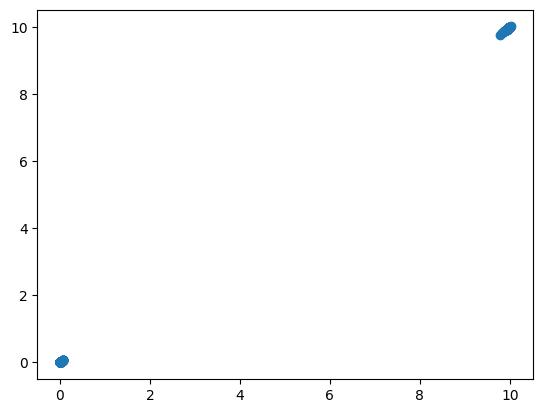

In [55]:
plt.scatter(normal_1, normal_1)

In [28]:
import random

In [29]:
random_timestamps = [random.randint(4,5) for i in range(0,100)]

In [56]:
sse = {}
for k in range(1,5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(normal_1.reshape(-1,1))
    #record sum of distances to centroids
    sse[k] = kmeans.inertia_


Text(0, 0.5, 'Avg Distance To Centroid')

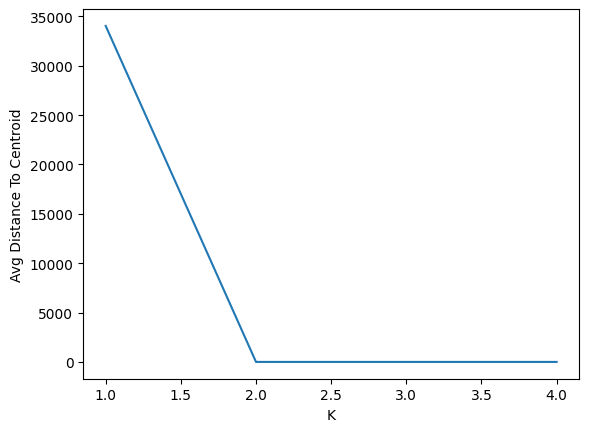

In [58]:
# Results indicate 2 clusters for the delta_t's of ONE particular source/dest pair
plt.plot(list(sse.keys()), list(sse.values()))
# Once cluster is small delta_t values when we burst... the other cluster is the 10-second gap in between bursts
plt.xlabel("K")
plt.ylabel("Avg Distance To Centroid")

In [59]:
optimal_kmeans = KMeans(n_clusters=2, random_state=42).fit(normal_1.reshape(-1,1))


In [60]:
len(optimal_kmeans.labels_)

9638

In [ ]:
len(normal_1) # list of delta_t for specific address pair

9638

In [63]:
optimal_kmeans.labels_
# 0 for one cluster, 1 for other

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [33]:
vals = {0:[],1:[]}
data = normal_1.reshape(-1,1)
for i,l in enumerate(optimal_kmeans.labels_):
    vals[l].append(data[i][0])

In [64]:
vals

{0: [np.float64(0.0001590251922607422),
  np.float64(0.00015091896057128906),
  np.float64(0.0005109310150146484),
  np.float64(0.0008320808410644531),
  np.float64(0.004842042922973633),
  np.float64(0.00016498565673828125),
  np.float64(0.0002589225769042969),
  np.float64(9.703636169433594e-05),
  np.float64(0.0006530284881591797),
  np.float64(0.00012993812561035156),
  np.float64(0.00012302398681640625),
  np.float64(0.00042891502380371094),
  np.float64(0.0007660388946533203),
  np.float64(0.010601043701171875),
  np.float64(0.00016498565673828125),
  np.float64(0.0002639293670654297),
  np.float64(0.000102996826171875),
  np.float64(0.0005960464477539062),
  np.float64(0.00012993812561035156),
  np.float64(0.00010919570922851562),
  np.float64(0.00043201446533203125),
  np.float64(0.0007579326629638672),
  np.float64(0.011544942855834961),
  np.float64(0.00016999244689941406),
  np.float64(0.00026607513427734375),
  np.float64(0.0004868507385253906),
  np.float64(0.0001602172851

In [66]:
# When we are in one burst of packets
avg_a = np.mean(vals[0])
std_a = np.std(vals[0])
print(f"Cluster 0 {avg_a} | Std Dev {std_a}")

Cluster 0 0.0013358441182082903 | Std Dev 0.0042314313695147035


In [67]:
# In between packet bursts
avg_a = np.mean(vals[1])
std_a = np.std(vals[1])
print(f"Cluster 1 {avg_a} | Std Dev {std_a}")

Cluster 1 9.965213841936562 | Std Dev 0.025704738878357246


In [70]:
new_anom_timestamp = 10.4

if new_anom_timestamp > (avg_a + std_a) or new_anom_timestamp < (avg_a - std_a):
    print("ANOMALOUS")
else:
    print("NORMAL")

ANOMALOUS


In [36]:
from sklearn.metrics import silhouette_score

In [69]:
for k in range(2,6):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    clusters = kmeans.labels_
    sc = silhouette_score(data, clusters, metric="euclidean")
    print(f"k = {k} {sc}")
# Further shows that there are in fact two clusters
# When we have more than 2 points, multiple points are sent to the same cluster

k = 2 0.9996996215927391
k = 3 0.9913437089177785
k = 4 0.9607803306978673
k = 5 0.9546676288826343
